In [24]:
import warnings

warnings.filterwarnings("ignore")

import pyspark.sql
from pyspark.sql.functions import *

import numpy as np
import pandas as pd

import wrangle as w

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

spark = pyspark.sql.SparkSession.builder.getOrCreate()

plt.style.use("ggplot")

# Acquire data

In [5]:
case_df = spark.read.csv("case.csv", header=True, inferSchema=True)
dept_df = spark.read.csv("dept.csv", header=True, inferSchema=True)
source_df = spark.read.csv("source.csv", header=True, inferSchema=True)



def wrangle_311(case_df, dept_df, source_df):
    df = case_df.join(source_df, on=case_df.source_id == source_df.source_id, how = 'left').drop(source_df.source_id)
    df = df.join(dept_df, on=df.dept_division == dept_df.dept_division, how = 'left').drop(dept_df.dept_division)
    return df

In [6]:
df = wrangle_311(case_df, dept_df, source_df)

In [8]:
df.show(1, False, True)

-RECORD 0------------------------------------------------------
 case_id                | 1014127332                           
 case_opened_date       | 1/1/18 0:42                          
 case_closed_date       | 1/1/18 12:29                         
 SLA_due_date           | 9/26/20 0:42                         
 case_late              | NO                                   
 num_days_late          | -998.5087616000001                   
 case_closed            | YES                                  
 dept_division          | Field Operations                     
 service_request_type   | Stray Animal                         
 SLA_days               | 999.0                                
 case_status            | Closed                               
 source_id              | svcCRMLS                             
 request_address        | 2315  EL PASO ST, San Antonio, 78207 
 council_district       | 5                                    
 source_username        | svcCRMLS      

In [18]:
df = w.wrangle_311_new(spark)

[wrangle.py] reading case.csv
[wrangle.py] handling data types
[wrangle.py] parsing dates
[wrangle.py] adding features
[wrangle.py] joining departments


In [19]:
df.show(1, False, True)

-RECORD 0----------------------------------------------------
 case_id              | 1014127332                           
 case_opened_date     | 2018-01-01 00:42:00                  
 case_closed_date     | 2018-01-01 12:29:00                  
 case_due_date        | 2020-09-26 00:42:00                  
 case_late            | false                                
 num_days_late        | -998.5087616000001                   
 case_closed          | true                                 
 service_request_type | Stray Animal                         
 SLA_days             | 999.0                                
 case_status          | Closed                               
 source_id            | svcCRMLS                             
 request_address      | 2315  EL PASO ST, San Antonio, 78207 
 council_district     | 005                                  
 num_weeks_late       | -142.6441088                         
 zipcode              | 78207                                
 case_ag

Answer the questions below by using a combination of the techniques discussed in the lesson that you think is appropriate.


 - How many different cases are there, by department?
 - Does the percentage of cases that are late vary by department?
 - On average, how late are the late cases by department?
 - What is the service type that is the most late? Just for Parks & Rec?
 - For the DSD/Code Enforcement department, what are the most common service request types? Look at other departments too.
 - Does whether or not its a weekend matter for when a case is opened/closed?
 - On average, how many cases are opened a day for the Customer Service department?
 - Does the number of service requests for the solid waste department vary by day of the week?

In [21]:
# How many different cases are there, by department?
df.groupby('department').count().show()

+--------------------+------+
|          department| count|
+--------------------+------+
|         Solid Waste|279270|
|Animal Care Services|116915|
|Trans & Cap Impro...| 96193|
|  Parks & Recreation| 19907|
|    Customer Service|  2849|
|        Metro Health|  5163|
|        City Council|    33|
|DSD/Code Enforcement|321374|
+--------------------+------+



Text(0.5, 0, 'Number of Cases')

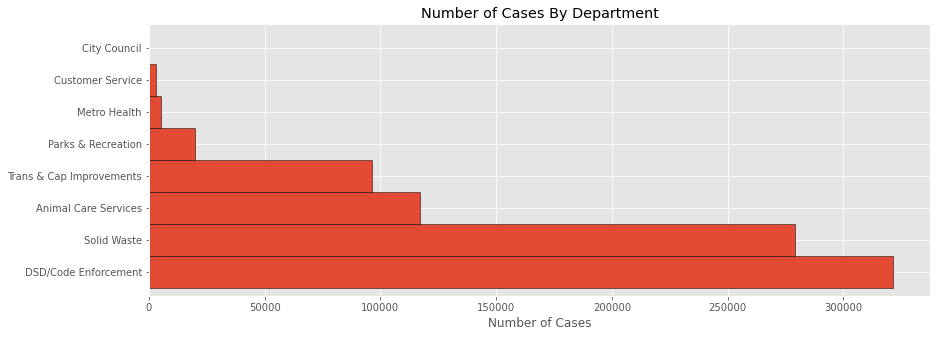

In [25]:
# First aggregate with spark
(
# group by    
    df.groupBy("department")
# aggregate by count    
    .count()
# then pass to pandas
    .toPandas()
# once its a dataframe, pass department as our index
    .set_index("department")["count"]
# sort our values for cleanliness of visualization
    .sort_values(ascending=False)
# pass our Series (department count values) to matplotlib
    .plot.barh(width=1, edgecolor="black", figsize=(14, 5))
)

plt.title("Number of Cases By Department")
plt.ylabel("")
plt.xlabel("Number of Cases")